In [1]:
import os
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, convolve, correlate
import matplotlib.pyplot as plt

from IPython.display import Audio

from helpers import *

In [150]:
# find 1 instance of the "gong" sound
rec_name = "mrrr_20150410_0920_002_PN.WAV"
t0, t1 = 9.9, 10.15
sr, rec = wavfile.read(os.path.join("long_rec", rec_name))
marker = rec[int(t0*sr):int(t1*sr)]
Audio(marker, rate=sr)

nperseg = 120

_, _, sxx_marker = spectrogram(marker, fs=sr, nperseg=nperseg)

/var/folders/r1/g8r4ph9s3h19bwdkrc7h_7sc0000gn/T/ipykernel_32911/3966032516.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, rec = wavfile.read(os.path.join("long_rec", rec_name))


In [149]:
def find_segments(song, sr, sxx_marker, win=("hann"), nps=120, 
                  peak_thresh=0.2, peak_dist=1500,
                  tol=20, seg_len=4.1, early_stop=0.1):

    f, t, sxx = spectrogram(song, fs=fs, window=win, nperseg=nps)

    # cross correlate with marker
    c = correlate(sxx, sxx_marker, mode="valid")
    c = np.squeeze(c)
    min_c, max_c = min(c), max(c)
    c = (c-min_c)/(max_c-min_c)

    peaks, _ = find_peaks(c, height=0.2, distance=1500)

    segments = []
    for p in peaks:
        seg_t1 = int(p * song.shape[0]/sxx.shape[1] - fs*early_stop)
        seg_t0 = int(max(seg_t1 - fs*seg_len, 0))
        segments.append([seg_t0, seg_t1])
    
    return segments

In [125]:
# print(sxx/t.shape[0])
print(3/(len(song)/sr/t.shape[0]))

1259.9870223503967


In [143]:
filename = filenames[2]
print(filenames)

sr, song = wavfile.read(os.path.join(base_dir, data_dir, filename))
f, t, sxx = spectrogram(song, fs=sr, nperseg=120)

print(sxx.shape)

c = correlate(sxx, sxx_marker, mode="valid")
print(c.shape)
c = np.squeeze(c)
min_c, max_c = min(c), max(c)
c= (c-min_c)/(max_c-min_c)

['bbom_20150324_0844_002_PN.WAV', 'bbom_20150324_0847_005_PN.WAV', 'bbom_20150324_0931_008_PN.WAV']
(61, 97089)


/var/folders/r1/g8r4ph9s3h19bwdkrc7h_7sc0000gn/T/ipykernel_32911/1929160478.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, song = wavfile.read(os.path.join(base_dir, data_dir, filename))


(1, 96986)


[ 2785 27655 33650 37245 44281 54957 65412 68217 71650 76205]


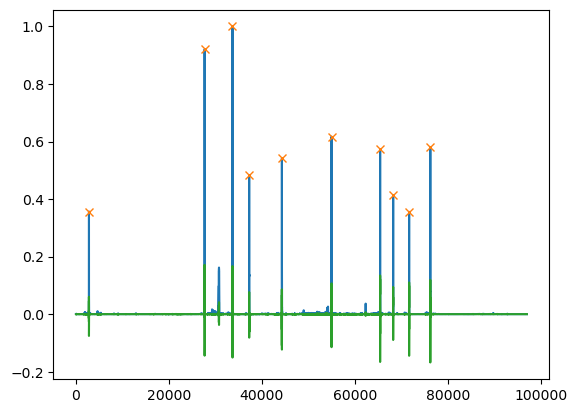

In [135]:
from scipy.signal import find_peaks

plt.plot(c)
# plt.plot(np.diff(c))

idx, _ = find_peaks(c, height=0.2, distance=1500)

plt.plot(idx, c[idx], "x")
plt.plot(np.diff(c))
# plt.xlim([12100, 12300])
print(idx)

# # plt.plot(all_high_points)
# print(peaks)

# # plt.plot(all_high_points)
# for p in peaks:
#     plt.axvline(p, ls="--")

# print(np.where(c > 0.05))
# plt.xlim()
# np.where(c > q)
# plt.plot(c.T-min(c))
# print(c - min(c) > 1e5)

In [89]:
from copy import deepcopy
# def consolidate_peaks(vals, max_width=20):
#     i = 0
#     peaks = []
#     curr_start = None
#     width = 0
#     while (i < len(vals)):
#         if (vals[i] == 1): # find a peak or in the peak
#             print(i)
#             if (curr_start is None): # find a peak
#                 curr_start = i
#             else:
#                 width += 1
#         else: # non peak or exit peak
#             if (width > 0 and width <= max_width):
#                 peaks.append(curr_start + width//2)
#             else:
#                 curr_start = None
#                 width = 0
#         i += 1
#     return peaks
        

def clear_peaks(all_idx, tol):
    peaks = []
    curr_peak = None
    i = 0
    while (i < len(all_idx)):
        curr_val = all_idx[i]
        if (curr_peak is None or curr_val > curr_peak+tol):
            peaks.append(curr_val)
            curr_peak = curr_val
        i += 1
    return peaks

def find_segments(song, fs, win=("hann"), nps=200, 
                  peak_thresh=5000, freq_thresh=1e4,
                  tol=20, seg_len=4.1, early_stop=0):

    f, t, sxx = spectrogram(song, fs=fs, window=win, nperseg=nps)
    print(song.shape)
    # print(t.shape, song.shape*fs/t.shape)

    # define an "edge" detecting kernel
    conv_elem = np.zeros((f.shape[0], 3))
    conv_elem[:, 0] = -1
    conv_elem[:, 1] = 1
    conv_elem[:, 2] = 1
    
    # convolve with spectrogram
    conv_prod = np.squeeze(convolve(sxx, conv_elem, mode="valid"))
    # plt.figure()
    plt.plot(np.sum(sxx, axis=0))

    # the frequency bin of interest
    all_tp = np.where(conv_prod > peak_thresh)[0] # temp peaks
    peaks = clear_peaks(all_tp, tol)

    segments = []
    for p in peaks:
        seg_t1 = int(p * song.shape[0]/sxx.shape[1] - fs*early_stop)
        seg_t0 = int(max(seg_t1 - fs*seg_len, 0))
        segments.append([seg_t0, seg_t1])
    
    return segments

In [147]:
YEAR = 2015

# overall folder
base_dir = f"/Volumes/My Passport/Song sparrow songs analysis/Song analysis - Jiayi/Named/"

data_dir = f"Recordings {YEAR}/Named" # where recordings are stored
save_dir = f"Segments_{YEAR}" # where segments will be saved

# list all wav files
filenames = list_wav(os.path.join(base_dir, data_dir))

In [160]:
# find 1 instance of the "gong" sound
rec_name = "mrrr_20150410_0920_002_PN.WAV"
t0, t1 = 10.01, 10.04
sr, rec = wavfile.read(os.path.join("long_rec", rec_name))

marker = rec[int(t0*sr):int(t1*sr)]
# _, _, sxx_marker = spectrogram(marker, fs=sr, nperseg=120)

# sr, song = wavfile.read(os.path.join(base_dir, data_dir, filename))
# f, t, sxx = spectrogram(song, fs=sr, nperseg=120)
print(int(t0*sr)-int(t1*sr))

-1322


/var/folders/r1/g8r4ph9s3h19bwdkrc7h_7sc0000gn/T/ipykernel_32284/58241865.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, rec = wavfile.read(os.path.join("long_rec", rec_name))


In [153]:
data = []
n_files = len(filenames)

for i, filename in enumerate(filenames):
    print(f"Segmenting {i+1}/{n_files}...")

    # get individual info
    ind, year, month, day = parse_filename(filename)

    # get segments in the wav file
    fs, song = wavfile.read(os.path.join(base_dir, data_dir, filename))
    segs = find_segments(song, fs, sxx_marker, nps=nperseg)

    for i, seg in enumerate(segs):
        t0, t1 = seg
        aud_seg = song[t0:t1]
        save_name= filename.split(".WAV")[0] + f"_{i}"
        spath = os.path.join(base_dir, save_dir, save_name)
        # make spec plot
        plot_spec(aud_seg, fs, save_path=spath+".png", max_freq=10000)
        # save audio
        wavfile.write(spath+".wav", rate=fs, data=scale_song(aud_seg))
        data.append([filename, spath+".wav", ind, year, month, day, t0, t1])
    


Segmenting 1/389...


/var/folders/r1/g8r4ph9s3h19bwdkrc7h_7sc0000gn/T/ipykernel_32911/701041680.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, song = wavfile.read(os.path.join(base_dir, data_dir, filename))


Segmenting 2/389...
Segmenting 3/389...
Segmenting 4/389...
Segmenting 5/389...
Segmenting 6/389...
Segmenting 7/389...
Segmenting 8/389...


/Users/jiayizhang/miniconda3/envs/KSCB/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Segmenting 9/389...
Segmenting 10/389...
Segmenting 11/389...
Segmenting 12/389...
Segmenting 13/389...
Segmenting 14/389...
Segmenting 15/389...
Segmenting 16/389...
Segmenting 17/389...
Segmenting 18/389...
Segmenting 19/389...
Segmenting 20/389...
Segmenting 21/389...
Segmenting 22/389...
Segmenting 23/389...
Segmenting 24/389...
Segmenting 25/389...
Segmenting 26/389...
Segmenting 27/389...
Segmenting 28/389...
Segmenting 29/389...
Segmenting 30/389...
Segmenting 31/389...
Segmenting 32/389...
Segmenting 33/389...
Segmenting 34/389...
Segmenting 35/389...
Segmenting 36/389...
Segmenting 37/389...
Segmenting 38/389...
Segmenting 39/389...
Segmenting 40/389...
Segmenting 41/389...
Segmenting 42/389...
Segmenting 43/389...
Segmenting 44/389...
Segmenting 45/389...
Segmenting 46/389...
Segmenting 47/389...
Segmenting 48/389...
Segmenting 49/389...
Segmenting 50/389...
Segmenting 51/389...
Segmenting 52/389...
Segmenting 53/389...
Segmenting 54/389...
Segmenting 55/389...
Segmenting 56/

In [155]:
import pandas as pd
# data.append([filename, ind, year, month, day, t0, t1])
df = pd.DataFrame(data, columns=["sourcefile", "filename", 
                                 "ind", "year", "month", "day",\
                                 "t0", "t1"])

In [158]:
df.to_csv(os.path.join(base_dir, save_dir, f"metadata_segments_{YEAR}.csv"))

In [ ]:
# find a way to segment out all the calls
data_dir = "long_rec"
filenames = os.listdir(data_dir)
print(filenames)
fs, song = wavfile.read(os.path.join(data_dir, filenames[0]))


['mrrr_20150410_0920_002_PN.WAV', 'mrrr_20150419_0756_002_MA.WAV']


/var/folders/r1/g8r4ph9s3h19bwdkrc7h_7sc0000gn/T/ipykernel_20969/187281246.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, song = wavfile.read(os.path.join(data_dir, filenames[0]))


In [71]:
YEAR = 2015
data_dir = f"/Volumes/My Passport/Song sparrow songs analysis/Song analysis - Jiayi/Named/Recordings {YEAR}/Named"
song_name = "mbrb_20150410_0840_008_PN.WAV"

sr, song = wavfile.read(os.path.join(data_dir, song_name))


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/My Passport/Song sparrow songs analysis/Song analysis - Jiayi/Named/Recordings 2015/Named/mbrb_20150410_0840_008_PN.WAV'

[ 31.90003229 -17.51337194 -17.48913459 ...   0.5214259    1.79518709
   1.10781574]
[1296 2958 4050 5151 6246 7313 8383 9652]


[[399822.0, 580632],
 [1144430.0, 1325240],
 [1633667.0, 1814477],
 [2126936.0, 2307746],
 [2617517.0, 2798327],
 [3095554.0, 3276364],
 [3574934.0, 3755744],
 [4143471.0, 4324281]]

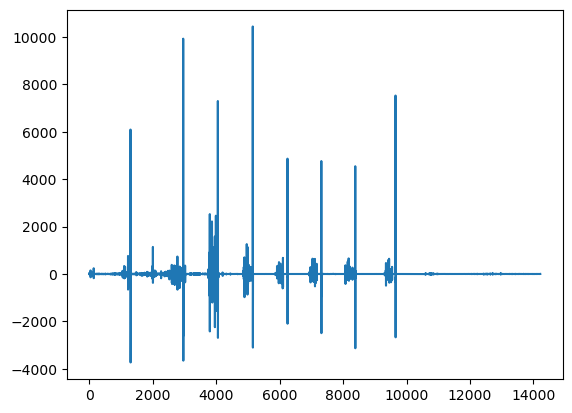

In [74]:
find_segments(song, sr)

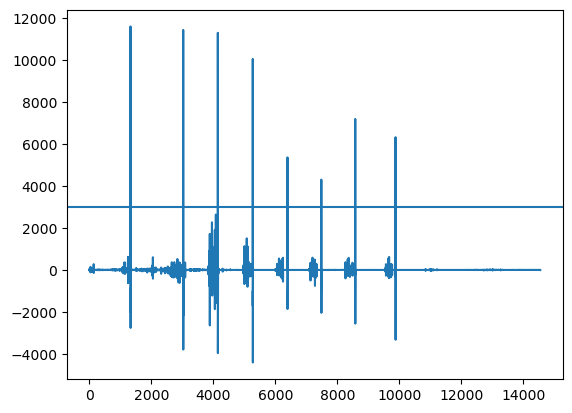

In [65]:
plt.plot(conv_prod.T)
plt.axhline(y=3000)

In [10]:
dt = 0.05 * sr
f, t, sxx = spectrogram(song, fs=sr, window=("hann"), nperseg=128)
print(np.where(f > 2e4))
print(sxx.shape)

(array([59, 60, 61, 62, 63, 64]),)
(65, 56882)


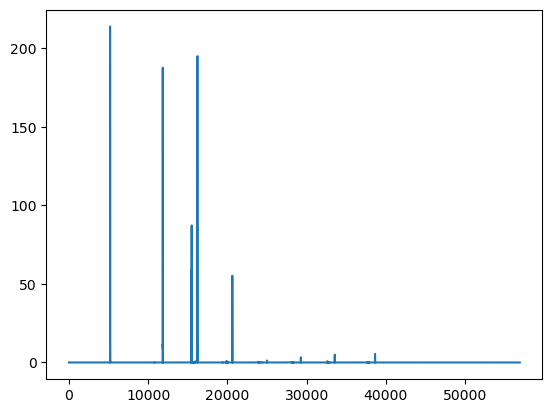

In [11]:
# plt.imshow(sxx)
plt.plot(sxx[60, :])

In [ ]:
clear_peaks(np.where(sxx[40, :] > 200), 20)

[array([3943, 3944, 3947, 9593, 9594, 9598])]

In [ ]:
sxx.shape
# (sxx.shape[1]/song.shape[0]) * song.shape[0]

(129, 10222)

In [ ]:
ds = song.shape[0]/sxx.shape[1]
# print(int(ds * 1971), int(ds*1973))
# Audio(song[int(ds * 1500):np.ceil(ds*1975)], rate=fs)
print(int(ds * 3947) / fs)


# ds * 1971 / fs

10.024467120181406
